In [69]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [32]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
# ctx['seed'] = 6660483
# ctx['spark'] = '''Title: Naples, Apple renews the Academy program with the Federico II University - Rai News
# Description: The academic training born between Cupertino and the University in 2016 restarts at the San Giovanni a Teduccio headquarters
# Original Language: Italian'''
print(ctx['seed'])
print(ctx['spark'])

3357669
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English


In [41]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_story']
print(ctx['prompt_story'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment

In [42]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
print(ctx['prompt_graph'])

1. Select some combination of 3-5 of the suggested confounder, mediator, and collider variables, in addition to the treatment and outcome variables to construct a realistic and interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than three parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a p

In [50]:
# nodes = ctx['nodes']
#################################################

nodes = [
    {"name": "Encryption Security Level",
     "description": "Whether encryption is secure against quantum computing attacks",
     "type": "outcome",
     "observed": True,
     "values": ["Not secure", "Secure"],
     "parents": ["Adoption of Quantum-Resistant Encryption", "Quantum Computing Advancement"]},
    
    {"name": "Development of Quantum-Resistant Encryption",
     "description": "Whether new quantum-resistant encryption methods are developed",
     "type": "treatment",
     "observed": True,
     "values": ["Not developed", "Developed"],
     "parents": ["Funding for Encryption Research", "Funding for Quantum Computing Research"]},
    
    {"name": "Quantum Computing Advancement",
     "description": "Whether there is significant advancement in quantum computing",
     "type": "treatment",
     "observed": True,
     "values": ["No advancement", "Significant advancement"],
     "parents": ["Funding for Quantum Computing Research"]},
    
    {"name": "Funding for Encryption Research",
     "description": "Amount of funding allocated for encryption research",
     "type": "confounder",
     "observed": True,
     "values": ["Insufficient funding", "Sufficient funding"],
     "parents": []},
    
    {"name": "Funding for Quantum Computing Research",
     "description": "Amount of funding allocated for quantum computing research",
     "type": "confounder",
     "observed": True,
     "values": ["Insufficient funding", "Sufficient funding"],
     "parents": []},
    
    {"name": "Adoption of Quantum-Resistant Encryption",
     "description": "Whether quantum-resistant encryption methods are adopted",
     "type": "mediator",
     "observed": True,
     "values": ["Not adopted", "Adopted"],
     "parents": ["Development of Quantum-Resistant Encryption", "Funding for Encryption Research"]},
    
    {"name": "Global Cybersecurity Threat Perception",
     "description": "The global perception of cybersecurity threats",
     "type": "collider",
     "observed": True,
     "values": ["Low perception", "High perception"],
     "parents": ["Development of Quantum-Resistant Encryption", "Quantum Computing Advancement"]}
]




#################################################
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

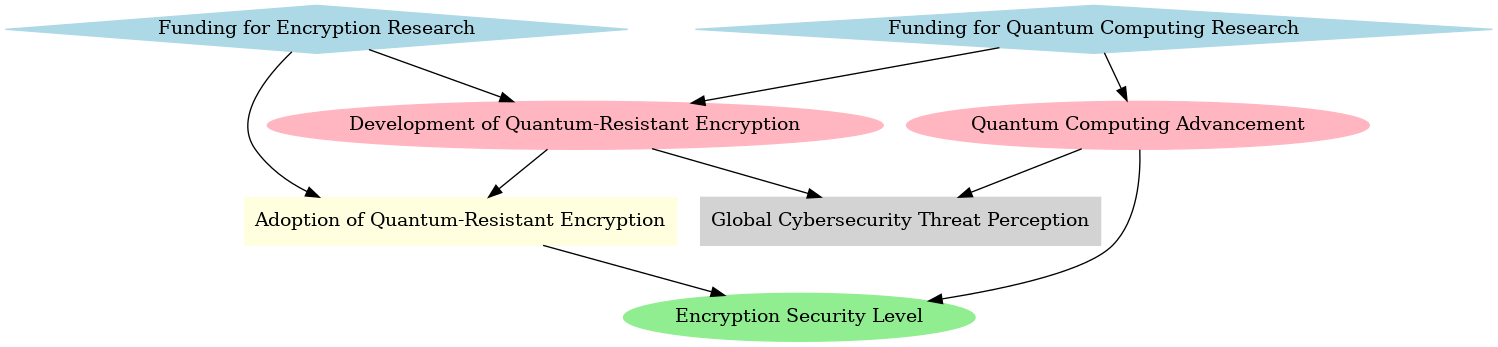

In [51]:
# G = ctx['graph']
# if 'graph' in ctx:
#     del ctx['graph']
# node_colors = {'treatment': 'lightcoral', 'outcome': 'lightgreen', 'confounder': 'lightblue', 'mediator': 'lightyellow', 'collider': 'lightgray'}
# colors = [node_colors[G.nodes[n]['type']] for n in G.nodes]
# plt.figure(figsize=(10, 6))
# pos = nx.circular_layout(G)
# nx.draw(G, pos, with_labels=True, node_color=colors, node_size=5000, font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)
# plt.title('Causal Graph', size=15);
# plt.tight_layout();

dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [53]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
print(ctx['prompt_stats'])

We have a causal bayes net based on the following article:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Funding for Encryption Research" is "Sufficient funding" (rather than "Insufficient funding")?
2. what is the probability that "Funding for Quantum Computing Research" is "Sufficient funding" (rather than "Insufficient funding")?
3. when "Funding for Encryption Research" is "Insufficient funding" and "Funding for Quantum Computing Research" is "Insufficient funding": what is the probability that "Development of Quantum-Resistant Encryption" is "Developed" (rather than "Not developed")?
4. when "Fundi

In [54]:
# probabilities = ctx['stats']
#################################################

probabilities = {
    1: [0.5, 0.7],  # Sufficient funding for encryption research likely due to increasing cybersecurity concerns.
    2: [0.6, 0.8],  # High interest in quantum computing likely leads to sufficient funding.
    3: [0.1, 0.3],  # Without funding, development of quantum-resistant encryption is less likely.
    4: [0.2, 0.4],  # Sufficient funding in quantum computing might indirectly support encryption development even if its own funding is low.
    5: [0.6, 0.8],  # Sufficient funding for encryption research should strongly facilitate development.
    6: [0.7, 0.9],  # High probability with sufficient funding in both areas.
    7: [0.2, 0.4],  # Quantum computing advancement is less likely with insufficient funding.
    8: [0.7, 0.9],  # Sufficient funding significantly increases the likelihood of advancement.
    9: [0.1, 0.3],  # Low adoption likely if encryption method is not developed and funding is insufficient.
    10: [0.2, 0.4], # Slightly higher chance of adoption due to sufficient funding, despite the lack of development.
    11: [0.4, 0.6], # Adoption more likely with development, even with insufficient funding.
    12: [0.7, 0.9], # High likelihood of adoption with both development and sufficient funding.
    13: [0.5, 0.7], # Moderate security if there is no advancement in quantum computing.
    14: [0.1, 0.3], # Security likely compromised with significant quantum computing advancement.
    15: [0.8, 0.9], # High security if quantum-resistant encryption is adopted without quantum computing advancement.
    16: [0.4, 0.6], # Even with adoption, significant quantum computing advancement poses risks.
    17: [0.3, 0.5], # Perceived threat might be moderate without advancement in quantum computing.
    18: [0.6, 0.8], # High perception of threat with significant quantum computing advancement.
    19: [0.4, 0.6], # Even with encryption development, no advancement in quantum computing might not raise threat perception significantly.
    20: [0.7, 0.9], # High threat perception likely with both encryption development and quantum computing advancement.
}



#################################################
ctx['stats'] = probabilities

In [55]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(50, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

-------------------------------------------  --------------  -----------------------  --------------------------------------------------------------
Development of Quantum-Resistant Encryption  Not developed   Developed                Whether new quantum-resistant encryption methods are developed
Quantum Computing Advancement                No advancement  Significant advancement  Whether there is significant advancement in quantum computing
Encryption Security Level                    Not secure      Secure                   Whether encryption is secure against quantum computing attacks
-------------------------------------------  --------------  -----------------------  --------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Funding for Encryption Research' means Amount of funding allocated for encryption research
'Funding for Quantum Computing Research' means Amount of funding allocated for quantum computing research
'Development of Quantum-Resistant Encryption' means Whether new quantum-resistant encryption methods are developed
'Quantum Computing Advancement' means Whether there is significant advancement in quantum computing
'Adoption of Quantum-Resistant Encryption' means Whether quantum-resistant encryption methods are adopted
'Encryption Security Level' means Whether encryption is secure against quantum computing attacks
'Global Cybersecurity Threat Perception' means The global perception of cybersecurity threats
Treatment Value          Treatment                                    Outcome Value    Outcome                          ATE    Correlation
-----------------------  -------------------------------------------  ---------------  -------------------------  ---------  -------------
Developed   

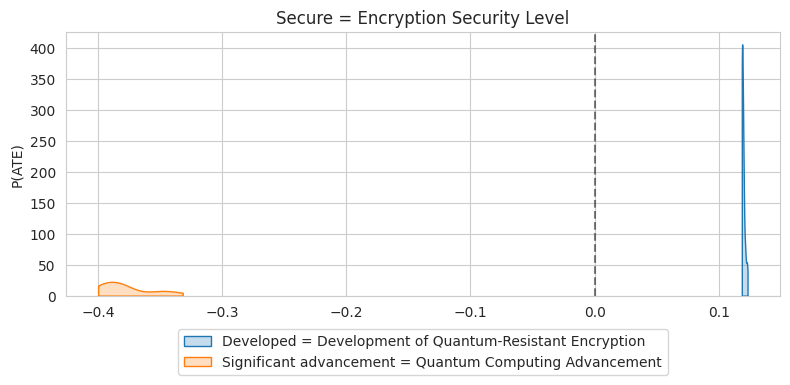

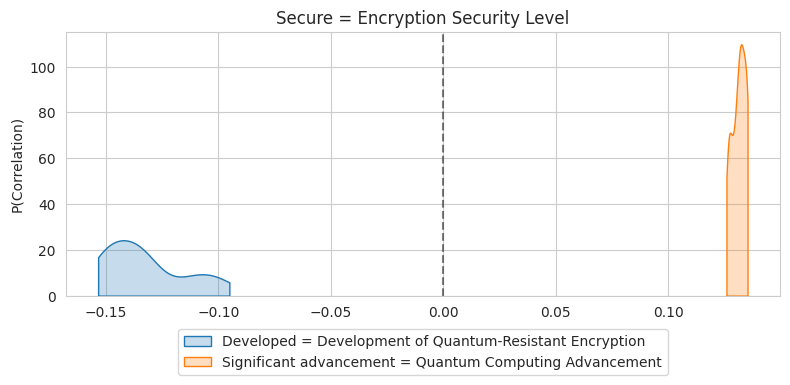

In [56]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

In [57]:
mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                                    ATE    Correlation  Outcome
---------------------------------------------------------  -----  -------------  ---------------------------------------------------------
Sufficient funding Funding for Encryption Research          0              0     Sufficient funding Funding for Quantum Computing Research
Sufficient funding Funding for Encryption Research          0.5           -0.61  Developed Development of Quantum-Resistant Encryption
Sufficient funding Funding for Encryption Research          0             -0     Significant advancement Quantum Computing Advancement
Sufficient funding Funding for Encryption Research          0.39           0.42  Adopted Adoption of Quantum-Resistant Encryption
Sufficient funding Funding for Encryption Research          0.11           0.17  Secure Encryption Security Level
Sufficient funding Funding for Encryption Research          0.05          -0.37  High perception Global Cybersecurity T

In [58]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('Development of Quantum-Resistant Encryption', 'Encryption Security Level', ['Funding for Encryption Research', 'Quantum Computing Advancement'])
('Quantum Computing Advancement', 'Encryption Security Level', ['Funding for Quantum Computing Research'])


In [59]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Funding for Encryption Research' (0='Insufficient funding', 1='Sufficient funding') means Amount of funding allocated for encryption research
Variable 'Funding for Quantum Computing Research' (0='Insufficient funding', 1='Sufficient f

In [60]:
# verbalizations = ctx['verbs']
#######################################################################

verbalizations = {
    "Funding for Encryption Research": {
        "descriptor": ["the financial support for encryption research", "the allocation of funds for encryption research"],
        "subject": "encryption research funding",
        "predicate0": ["is lacking", "falls short of the necessary amount"],
        "predicate1": ["is adequate", "meets the required level"],
        "pronoun": "it",
        "nounclause0": ["there's a shortfall in funding for encryption research", "encryption research is underfunded"],
        "nounclause1": ["there's enough funding for encryption research", "encryption research receives sufficient financial support"],
        "preposition": "among",
        "domain": "encryption research projects",
        "subclause0": ["funding is insufficient", "the budget doesn't meet the needs"],
        "subclause1": ["funding is sufficient", "the budget meets the research requirements"],
        "condition0": ["if funding for encryption research is inadequate", "where encryption research funding falls short"],
        "condition1": ["if funding for encryption research is sufficient", "where encryption research has adequate funding"],
        "action0": ["funding for encryption research is decreased", "the budget for encryption research is cut"],
        "action1": ["funding for encryption research is increased", "more financial resources are allocated to encryption research"]
    },
    "Funding for Quantum Computing Research": {
        "descriptor": ["the financial backing for quantum computing research", "the investment in quantum computing research"],
        "subject": "quantum computing research funding",
        "predicate0": ["is not at an optimal level", "is below par"],
        "predicate1": ["is robust", "is at a desirable level"],
        "pronoun": "it",
        "nounclause0": ["quantum computing research suffers from inadequate funding", "there's a lack of sufficient investment in quantum computing research"],
        "nounclause1": ["quantum computing research is well-funded", "there's strong financial support for quantum computing research"],
        "preposition": "within",
        "domain": "quantum computing initiatives",
        "subclause0": ["the funding doesn't meet the sector's demands", "there is a funding deficit"],
        "subclause1": ["the funding surpasses the sector's needs", "there is ample financial support"],
        "condition0": ["when quantum computing research lacks enough funding", "if the investment in quantum computing research is insufficient"],
        "condition1": ["when quantum computing research is adequately funded", "if there is substantial investment in quantum computing research"],
        "action0": ["financial support for quantum computing research is reduced", "the budget for quantum computing research is slashed"],
        "action1": ["investment in quantum computing research is boosted", "more funds are directed towards quantum computing research"]
    },
    "Development of Quantum-Resistant Encryption": {
        "descriptor": ["the progress in quantum-resistant encryption development", "the advancement of quantum-resistant encryption"],
        "subject": "the development of quantum-resistant encryption",
        "predicate0": ["hasn't been achieved", "remains incomplete"],
        "predicate1": ["has been successful", "has reached fruition"],
        "pronoun": "it",
        "nounclause0": ["quantum-resistant encryption hasn't been realized", "there's no breakthrough in quantum-resistant encryption"],
        "nounclause1": ["quantum-resistant encryption is a reality", "there's a breakthrough in quantum-resistant encryption"],
        "preposition": "among",
        "domain": "encryption technologies",
        "subclause0": ["there's no development of quantum-resistant methods", "the creation of quantum-resistant encryption is lacking"],
        "subclause1": ["there's successful development of quantum-resistant methods", "quantum-resistant encryption has been achieved"],
        "condition0": ["if quantum-resistant encryption isn't developed", "where no quantum-resistant encryption exists"],
        "condition1": ["if quantum-resistant encryption is developed", "where quantum-resistant encryption is available"],
        "action0": ["efforts to develop quantum-resistant encryption are halted", "the project to create quantum-resistant encryption is stopped"],
        "action1": ["efforts to develop quantum-resistant encryption are intensified", "the push for creating quantum-resistant encryption is accelerated"]
    },
    "Quantum Computing Advancement": {
        "descriptor": ["the progress in quantum computing", "the evolution of quantum computing technology"],
        "subject": "quantum computing advancement",
        "predicate0": ["hasn't made significant strides", "is stagnant"],
        "predicate1": ["has seen significant breakthroughs", "is rapidly evolving"],
        "pronoun": "it",
        "nounclause0": ["there's no major progress in quantum computing", "quantum computing technology remains underdeveloped"],
        "nounclause1": ["quantum computing has made leaps and bounds", "significant advances in quantum computing have been made"],
        "preposition": "across",
        "domain": "quantum computing sectors",
        "subclause0": ["significant advancement is yet to be seen", "there's a lack of groundbreaking progress"],
        "subclause1": ["remarkable progress is evident", "groundbreaking advancements are achieved"],
        "condition0": ["if quantum computing doesn't advance significantly", "when there's no major progress in quantum computing"],
        "condition1": ["if quantum computing advances significantly", "when quantum computing makes substantial strides"],
        "action0": ["development in quantum computing is slowed down", "the pace of quantum computing progress is reduced"],
        "action1": ["quantum computing development is expedited", "the pace of quantum computing progress is increased"]
    },
    "Adoption of Quantum-Resistant Encryption": {
        "descriptor": ["the uptake of quantum-resistant encryption methods", "the implementation of quantum-resistant encryption"],
        "subject": "the adoption of quantum-resistant encryption",
        "predicate0": ["hasn't occurred", "is not widespread"],
        "predicate1": ["is becoming common", "is being embraced"],
        "pronoun": "it",
        "nounclause0": ["quantum-resistant encryption isn't widely adopted", "there's little to no use of quantum-resistant encryption"],
        "nounclause1": ["quantum-resistant encryption is gaining traction", "quantum-resistant encryption is increasingly used"],
        "preposition": "among",
        "domain": "technology firms",
        "subclause0": ["the adoption is lagging", "the use is minimal or non-existent"],
        "subclause1": ["widespread adoption is seen", "a growing number of firms are implementing it"],
        "condition0": ["if quantum-resistant encryption isn't adopted", "where there's no usage of quantum-resistant encryption"],
        "condition1": ["if quantum-resistant encryption is adopted", "where quantum-resistant encryption is being used"],
        "action0": ["the rollout of quantum-resistant encryption is delayed", "the adoption of quantum-resistant encryption is postponed"],
        "action1": ["the rollout of quantum-resistant encryption is accelerated", "the adoption of quantum-resistant encryption is pushed forward"]
    },
    "Encryption Security Level": {
        "descriptor": ["the robustness of encryption against quantum attacks", "the security level of encryption in the quantum era"],
        "subject": "encryption security",
        "predicate0": ["is vulnerable to quantum computing", "isn't up to the mark against quantum threats"],
        "predicate1": ["can withstand quantum computing attacks", "is strong against quantum threats"],
        "pronoun": "it",
        "nounclause0": ["encryption is not safe from quantum computing threats", "there's a risk to encryption from quantum advancements"],
        "nounclause1": ["encryption holds up against quantum computing threats", "encryption remains secure despite quantum advancements"],
        "preposition": "in",
        "domain": "encryption standards",
        "subclause0": ["the security is compromised", "the defenses are inadequate against quantum computing"],
        "subclause1": ["the security is adequate", "the defenses hold strong against quantum computing"],
        "condition0": ["if encryption security is not up to quantum standards", "when encryption is vulnerable to quantum computing"],
        "condition1": ["if encryption security withstands quantum challenges", "when encryption is resilient against quantum computing"],
        "action0": ["the strength of encryption against quantum attacks is weakened", "quantum computing threats become more of a concern for encryption"],
        "action1": ["encryption is reinforced against quantum attacks", "measures to secure encryption against quantum threats are enhanced"]
    },
    "Global Cybersecurity Threat Perception": {
        "descriptor": ["the level of global cybersecurity threat awareness", "public awareness of cybersecurity threats globally"],
        "subject": "the public",
        "predicate0": ["is not highly aware of cybersecurity threats", "does not perceive a high threat from cyber attacks"],
        "predicate1": ["is acutely aware of cybersecurity threats", "perceives a high threat from cyber attacks"],
        "pronoun": "it",
        "nounclause0": ["there is a low awareness of cybersecurity threats", "the public does not see cyber attacks as a high threat"],
        "nounclause1": ["there is a high awareness of cybersecurity threats", "the public sees cyber attacks as a high threat"],
        "preposition": "among",
        "domain": "the public",
        "subclause0": ["cybersecurity threats are not a major concern", "there is little concern about cyber attacks"],
        "subclause1": ["cybersecurity threats are a major concern", "there is a significant concern about cyber attacks"],
        "condition0": ["if the public is not aware of cybersecurity threats", "if cyber attacks are not seen as a major threat"],
        "condition1": ["if the public is highly aware of cybersecurity threats", "if cyber attacks are seen as a major threat"],
        "action0": ["cybersecurity threat awareness is reduced", "public concern about cyber attacks is diminished"],
        "action1": ["cybersecurity threat awareness is increased", "public concern about cyber attacks is heightened"]
    }
}

#######################################################################
ctx['verbs'] = verbalizations

In [61]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
print(ctx['prompt_questions'])

We have a causal bayes net based on the following article:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Now we would like to use this model to generate some interesting research questions:

1. Write a short two sentence introduction to describe motivation and purpose of the causal model to provide context to the questions in an conversational/debate setting. Where possible, include relevant details from the original article headline or related information you can infer therefrom. Avoid discussing specific structural properties or assumptions in the causal graph, and instead focus on the overall motivation and potential applications for the model. Refrain from mentioning words like "causal inference" or "model".
Make sure not to use any technical terms from causal inferenc

In [65]:
# setting = ctx['questions']
#######################################################################


setting = {
    "introduction": "In a world where quantum computing is rapidly evolving, understanding how this technological leap affects cybersecurity, particularly encryption, is crucial. This topic, highlighted by the Telegraph's article on the race to upgrade encryption against quantum threats, is ripe for exploration and debate.",
    "overview": "Imagine a web of factors where how much money is put into research influences the development of new encryption methods and the advancement of quantum computing. This web also includes how these developments impact the adoption of new encryption methods, the overall security of encryption, and public perception of cybersecurity threats.",
    "questions": {
        1: {"question": "Does focusing on developing quantum-resistant encryption decrease the overall encryption security level?",
            "answer": "no",
            "explanation": "Developing quantum-resistant encryption is aimed at increasing encryption security, especially against quantum computing threats.",
            "wrong_explanation": "Developing quantum-resistant encryption could potentially lower encryption security by diverting resources from other vital security measures."
        },
        2: {"question": "Does advancing quantum computing technology lead to a decrease in encryption security?",
            "answer": "yes",
            "explanation": "Significant advancement in quantum computing poses a threat to current encryption standards, potentially reducing encryption security.",
            "wrong_explanation": "Advancement in quantum computing could potentially enhance encryption security by providing more robust computational tools."
        },
        3: {"question": "Is the impact on encryption security greater from developing quantum-resistant encryption than from quantum computing advancement?",
            "answer": "no",
            "explanation": "The threat posed by quantum computing advancement to current encryption methods is likely more significant than the protective effect of developing quantum-resistant encryption.",
            "wrong_explanation": "The development of quantum-resistant encryption has a more substantial impact on improving encryption security than the potential threat posed by quantum computing advancement."
        },
        4: {"question": "Is the impact on encryption security from quantum computing advancement more significant than from developing quantum-resistant encryption?",
            "answer": "yes",
            "explanation": "The potential threat to encryption security from quantum computing advancement is likely to be more substantial than the benefits gained from developing quantum-resistant encryption.",
            "wrong_explanation": "The benefits of developing quantum-resistant encryption are likely more impactful on encryption security than the threats posed by quantum computing advancement."
        },
        5: {"question": "If funding for encryption research is low, does developing quantum-resistant encryption still positively impact encryption security?",
            "answer": "yes",
            "explanation": "Even with limited funding, the development of quantum-resistant encryption can still contribute positively to enhancing encryption security.",
            "wrong_explanation": "Insufficient funding for encryption research means that any development in quantum-resistant encryption would likely have little to no positive impact on encryption security."
        },
        6: {"question": "If funding for encryption research is low, does advancing quantum computing technology negatively impact encryption security?",
            "answer": "yes",
            "explanation": "Advancement in quantum computing can pose a threat to encryption security, especially when funding for encryption research is insufficient to develop new protective measures.",
            "wrong_explanation": "Low funding for encryption research would not impact the negative effects of quantum computing advancement on encryption security."
        },
        7: {"question": "With insufficient encryption research funding, is the negative impact on encryption security greater from quantum computing advancement than from the lack of development in quantum-resistant encryption?",
            "answer": "yes",
            "explanation": "The threat to encryption security from advancing quantum computing is likely to be more severe than the impact of not developing new quantum-resistant encryption methods.",
            "wrong_explanation": "The lack of development in quantum-resistant encryption has a more significant negative impact on encryption security than the advancement of quantum computing."
        },
        8: {"question": "With low encryption research funding, is the negative impact on encryption security from lack of quantum-resistant encryption development less than from quantum computing advancement?",
            "answer": "yes",
            "explanation": "Advancing quantum computing poses a greater threat to encryption security than the absence of new developments in quantum-resistant encryption under conditions of low funding.",
            "wrong_explanation": "Under low funding conditions, the absence of developments in quantum-resistant encryption has a more severe impact on encryption security than advancements in quantum computing."
        },
        9: {"question": "If encryption research is well-funded, does developing quantum-resistant encryption positively impact encryption security?",
            "answer": "yes",
            "explanation": "Sufficient funding in encryption research likely facilitates the effective development of quantum-resistant encryption, enhancing encryption security.",
            "wrong_explanation": "Even with sufficient funding, developing quantum-resistant encryption might not have a significant positive impact on encryption security."
        },
        10: {"question": "With ample funding for encryption research, does advancing quantum computing technology still pose a threat to encryption security?",
            "answer": "yes",
            "explanation": "Despite sufficient funding for encryption research, the advancement in quantum computing technology can still pose a significant threat to encryption security.",
            "wrong_explanation": "Sufficient funding for encryption research should mitigate any negative impacts of quantum computing advancement on encryption security."
        },
        11: {"question": "With sufficient funding for encryption research, is the negative impact on encryption security from quantum computing advancement less than from the lack of development in quantum-resistant encryption?",
            "answer": "no",
            "explanation": "Even with good funding, the threat from advancing quantum computing could still be greater than the impact of not developing quantum-resistant encryption.",
            "wrong_explanation": "With sufficient funding, the lack of development in quantum-resistant encryption could have a more severe impact on encryption security than the advancement of quantum computing."
        },
        12: {"question": "Is the positive impact on encryption security from developing quantum-resistant encryption greater with sufficient encryption research funding than the negative impact from quantum computing advancement?",
            "answer": "yes",
            "explanation": "Adequate funding for encryption research likely makes the development of quantum-resistant encryption more effective in enhancing security than the threat posed by quantum computing advancement.",
            "wrong_explanation": "Despite sufficient funding, the negative impact of quantum computing advancement on encryption security is still greater than the benefits of developing quantum-resistant encryption."
        },
        13: {"question": "Does the positive impact on encryption security from developing quantum-resistant encryption decrease when funding for encryption research increases?",
            "answer": "no",
            "explanation": "Increased funding for encryption research is likely to enhance the positive impact of developing quantum-resistant encryption on encryption security.",
            "wrong_explanation": "Higher funding for encryption research could potentially dilute the positive impact of developing quantum-resistant encryption on encryption security."
        },
        14: {"question": "Is the positive impact on encryption security from developing quantum-resistant encryption stronger with more funding for encryption research?",
            "answer": "yes",
            "explanation": "More funding for encryption research is expected to strengthen the positive impact of developing quantum-resistant encryption on encryption security.",
            "wrong_explanation": "Increased funding for encryption research does not necessarily mean a stronger positive impact from developing quantum-resistant encryption on encryption security."
        },
        15: {"question": "Does advancing quantum computing technology have a more significant negative impact on encryption security with more funding for encryption research?",
            "answer": "no",
            "explanation": "Increased funding for encryption research is likely to counteract the negative impact of quantum computing advancement on encryption security.",
            "wrong_explanation": "More funding for encryption research might exacerbate the negative impact of quantum computing advancement on encryption security."
        },
        16: {"question": "Is the negative impact on encryption security from advancing quantum computing technology greater with low funding for encryption research than with high funding?",
            "answer": "yes",
            "explanation": "Low funding for encryption research likely makes it harder to counteract the negative impacts of advancing quantum computing on encryption security.",
            "wrong_explanation": "Even with low funding, the impact of quantum computing advancement on encryption security could be the same as with high funding."
        },
        17: {"question": "With low funding for quantum computing research, does developing quantum-resistant encryption still positively impact encryption security?",
            "answer": "yes",
            "explanation": "Even with limited funding for quantum computing research, the development of quantum-resistant encryption can still contribute positively to encryption security.",
            "wrong_explanation": "Insufficient funding for quantum computing research could hinder the positive impact of developing quantum-resistant encryption on encryption security."
        },
        18: {"question": "If funding for quantum computing research is low, does this lead to a decrease in encryption security?",
            "answer": "no",
            "explanation": "Low funding for quantum computing research might not significantly advance quantum computing to a level that threatens current encryption standards.",
            "wrong_explanation": "Insufficient funding for quantum computing research could still lead to advancements that pose a threat to encryption security."
        },
        19: {"question": "With insufficient funding for quantum computing research, is the positive impact on encryption security from developing quantum-resistant encryption greater than the negative impact from lack of quantum computing advancement?",
            "answer": "yes",
            "explanation": "The development of quantum-resistant encryption is likely to have a more positive impact on encryption security than the reduced threat from a lack of advancement in quantum computing.",
            "wrong_explanation": "Even with low funding for quantum computing research, the lack of advancement in quantum computing could pose a greater threat to encryption security than the benefits of developing quantum-resistant encryption."
        },    
        20: {
            "question": "Is the impact of insufficient funding for quantum computing research on the development of quantum-resistant encryption smaller than its impact on the advancement of quantum computing itself?",
            "answer": "yes",
            "explanation": "Insufficient funding for quantum computing research is likely to have a smaller impact on the development of quantum-resistant encryption compared to its more direct effect on the advancement of quantum computing.",
            "wrong_explanation": "Insufficient funding for quantum computing research has a larger impact on the development of quantum-resistant encryption than on the advancement of quantum computing itself."
        },
        21: {
            "question": "Does sufficient funding for quantum computing research positively influence the development of quantum-resistant encryption?",
            "answer": "yes",
            "explanation": "Sufficient funding for quantum computing research likely fosters a positive environment for the development of quantum-resistant encryption.",
            "wrong_explanation": "Sufficient funding for quantum computing research does not contribute positively to the development of quantum-resistant encryption."
        },
        22: {
            "question": "Does sufficient funding for quantum computing research hinder the significant advancement in quantum computing?",
            "answer": "no",
            "explanation": "Sufficient funding for quantum computing research is more likely to facilitate rather than hinder significant advancements in the field.",
            "wrong_explanation": "Sufficient funding for quantum computing research actually leads to a decrease in significant advancements in quantum computing."
        },
        23: {
            "question": "Is the positive effect of sufficient funding for quantum computing research on the development of quantum-resistant encryption smaller than its effect on quantum computing advancement?",
            "answer": "yes",
            "explanation": "While sufficient funding positively impacts both areas, its effect is likely more pronounced on the direct field of quantum computing advancement than on the development of quantum-resistant encryption.",
            "wrong_explanation": "Sufficient funding for quantum computing research has a larger positive effect on the development of quantum-resistant encryption than on quantum computing advancement."
        },
        24: {
            "question": "Does the absolute effect of sufficient funding for quantum computing research have a smaller impact on the development of quantum-resistant encryption than on the advancement of quantum computing?",
            "answer": "yes",
            "explanation": "The absolute impact of funding is likely more significant in the direct area of quantum computing advancement than on the development of quantum-resistant encryption.",
            "wrong_explanation": "The absolute impact of sufficient funding for quantum computing research is greater on the development of quantum-resistant encryption than on the advancement of quantum computing."
        },
        25: {
            "question": "Is the positive impact of sufficient funding for quantum computing research on the development of quantum-resistant encryption smaller when compared to insufficient funding for the same research?",
            "answer": "no",
            "explanation": "Sufficient funding for quantum computing research likely has a greater positive impact on the development of quantum-resistant encryption compared to a scenario with insufficient funding.",
            "wrong_explanation": "Sufficient funding for quantum computing research has a smaller positive impact on the development of quantum-resistant encryption compared to insufficient funding."
        },
        26: {
            "question": "Is the absolute effect of sufficient funding for quantum computing research on the development of quantum-resistant encryption smaller compared to the effect of insufficient funding?",
            "answer": "no",
            "explanation": "The absolute effect of sufficient funding on the development of quantum-resistant encryption is likely greater than the effect of insufficient funding.",
            "wrong_explanation": "The absolute effect of sufficient funding on the development of quantum-resistant encryption is smaller than that of insufficient funding."
        },
        27: {
            "question": "Does insufficient funding for quantum computing research lead to less advancement in quantum computing compared to sufficient funding?",
            "answer": "yes",
            "explanation": "Insufficient funding typically hampers progress, so quantum computing is likely to advance less with insufficient funding than with sufficient funding.",
            "wrong_explanation": "Insufficient funding for quantum computing research leads to greater advancement in the field than sufficient funding."
        },
        28: {
            "question": "Is the absolute impact of sufficient funding on quantum computing advancement smaller than that of insufficient funding?",
            "answer": "no",
            "explanation": "Sufficient funding is likely to have a greater absolute impact on quantum computing advancement than insufficient funding.",
            "wrong_explanation": "Insufficient funding has a larger absolute impact on quantum computing advancement than sufficient funding."
        }
    }
}



#######################################################################
setting['questions'] = [setting['questions'][i] for i in range(1, len(setting['questions'])+1)]
ctx['questions'] = setting

In [67]:
i = len(list(ctx._root.glob("*.json")))+1
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i}'
while path.exists():
    i += 1
    path = ctx._root / f'test{i}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id)

PosixPath('/home/fleeb/workspace/code/cladder/novo-data/stories/test22.json')

In [27]:
ctx['stats'] = {int(k): v for k, v in ctx['stats'].items()}
ctx['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in ctx['verbs'].items()}
for k, v in ctx['verbs'].items():
    for k2, v2 in v.items():
        if 'value' in v2:
            v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
ctx['questions']['questions'] = {int(k): v for k, v in ctx['questions']['questions'].items()}

In [28]:
rawverbs = ctx['verbs']
rawvars = {node['name']: node for node in ctx['nodes']}

In [29]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('ParticipationAppleAcademy', 'EmploymentRateTech', ['LocalEconCond'])
('UnivIndustryCollab', 'EmploymentRateTech', ['LocalEconCond'])


In [30]:
qkey = random.choice(list(ctx['questions']['questions']))
qkey = 3
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][qkey-1]
print(ctx['query_description'].split('\n')[qkey-1])
print(query)
qinfo

	3. ATE('ParticipationAppleAcademy') < ATE('UnivIndustryCollab')
{'treatment1': 'ParticipationAppleAcademy', 'treatment2': 'UnivIndustryCollab', 'query': 'ate', 'type': 'ate-compare', 'criterion': '<'}


{'question': 'Is participating in the Apple Academy program more influential in increasing tech sector employment than active university-industry collaboration?',
 'answer': 'no',
 'explanation': 'Active university-industry collaboration tends to have a more significant impact on employment in the tech sector compared to individual participation in programs like Apple Academy.',
 'wrong_explanation': 'Participation in the Apple Academy program is more effective in increasing employment in the tech sector compared to university-industry collaboration.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [63]:
next(iter(rawverbs.values()))

{1: {'variable': ['the age of the refinery',
   'how long the refinery has been operational']},
 2: {'subject': 'the refinery',
  'value': {0: ['is a new facility', 'has been recently established'],
   1: ['has been operating for many years', 'is an older establishment']}},
 3: {'value': {0: ['the refinery is newly built',
    'the refinery has been recently established'],
   1: ['the refinery is quite old',
    'the refinery has many years of operation']}},
 4: {'domain': 'refineries',
  'value': {0: ['are new establishments', 'have been recently built'],
   1: ['are older facilities', 'have been operating for many years']}},
 5: {'value': {0: ['the refinery is a new establishment',
    'the refinery has been recently constructed'],
   1: ['the refinery is an old establishment',
    'the refinery has been operating for a long time']}},
 6: {'value': {0: ['If the refinery is newly established',
    'In newer refineries'],
   1: ['If the refinery has been around for many years',
    'In

In [ ]:
varverbs = {}

for var, raw in rawverbs.items():
    info = {'values': {0: {}, 1: {}}}
    info0 = info['values'][0]
    info1 = info['values'][1]
    
    info['variable'] = raw[1]['variable']
    info['subject'] = raw[2]['subject']
    info['domain'] = raw[3]['domain']
    
    
    
    for i in [0, 1]:
        info_val = raw[2]['value'][i]
        info_val['verb'] = raw[2]['value'][i]
        

    varverbs[var] = info

In [62]:
rawverbs[treatment1['name']]

{1: {'variable': ['the safety protocols in place at the refinery',
   'how well the refinery follows safety guidelines']},
 2: {'subject': 'the refinery',
  'value': {0: ['lacks adequate safety protocols',
    'has insufficient safety measures'],
   1: ['maintains adequate safety protocols', 'has robust safety measures']}},
 3: {'value': {0: ['safety protocols are inadequate',
    'safety measures are not up to standard'],
   1: ['safety protocols are thoroughly implemented',
    'safety measures are comprehensive']}},
 4: {'domain': 'refineries',
  'value': {0: ['lack adequate safety measures',
    'do not follow safety guidelines properly'],
   1: ['have robust safety protocols',
    'adhere strictly to safety guidelines']}},
 5: {'value': {0: ['safety protocols are not followed properly',
    'safety measures are neglected'],
   1: ['safety protocols are strictly followed',
    'safety measures are taken seriously']}},
 6: {'value': {0: ['If safety protocols are lacking',
    'In re

In [28]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
example_tmpl = '{subject} often {value}.'

In [35]:
rawverbs

{'Presidential Engagement in Climate Discussions': {'1': {'variable': ['presidential involvement in climate talks',
    "the president's active participation in climate discussions"]},
  '2': {'subject': 'the president',
   'value': {'0': ['is not involved in climate discussions',
     'does not engage in climate talks'],
    '1': ['actively participates in climate discussions',
     'is deeply involved in climate talks']}},
  '3': {'value': {'0': ['the president is not engaged in climate talks',
     'there is no presidential involvement in climate discussions'],
    '1': ['the president is actively engaged in climate talks',
     'there is direct presidential involvement in climate discussions']}},
  '4': {'domain': 'instances of climate discussions',
   'value': {'0': ['do not include presidential engagement',
     "lack the president's involvement"],
    '1': ['include active presidential participation',
     "feature the president's active involvement"]}},
  '5': {'value': {'0': [

In [80]:
prompt = FileTemplate('motivation').fill_in(ctx)
print(prompt)

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "mode

In [77]:
{
  "introduction": "With the rise of quantum computing posing a real challenge to current encryption methods, there's a fascinating question about how prepared different tech companies are for this change. By examining the patterns in investments made by these companies into quantum-safe technologies, we can get a sense of who's leading and who might be lagging in this race. This exploration would involve looking at the amount and types of investments over the past few years, delving into the sectors these companies belong to, and assessing their geographical distribution.",
  "title": "Quantum_Leap_In_Encryption_Preparedness"
}


{'introduction': "Imagine we're tracking a high-stakes race where companies around the world are scrambling to make their secrets quantum-proof. We'd gather data on how different start-ups are updating their encryption methods, noting things like the type of technology they're using, their progress speed, and the investments they're receiving. By looking at these pieces, we can understand who's leading in this crucial tech shift and what strategies are proving most effective.",
 'proposed_title': 'QuantumLeap_EncryptionRace'}

In [ ]:

# For example, if the article is about some political decision or issue in the economy, then we can imagine using that article (and some implied associated data) to analyze how some specific company should adjust investments or how some associated economic indicator will change. 


In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args